In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv("/content/final_imputed_data.csv")

In [3]:
df.head()

,PATNO,COHORT,subgroup,YEAR,visit_date,age,age_at_visit,SEX,EDUCYRS,fampd_bin,...,orthostasis,td_pigd,NP1COG,APOE_e4,NHY,duration_yrs,Years_with_PD,PD v/s NON-PD,month_year,diabetes_flag
0,3000,2,Healthy Control,3,2014-03-01,69.139726,72.254795,0,18.0,2.0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0,03-2014,0
1,3000,2,Healthy Control,4,2015-03-01,69.139726,73.252055,0,18.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,03-2015,0
2,3000,2,Healthy Control,5,2016-04-01,69.139726,74.304110,0,18.0,2.0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0,04-2016,0
3,3000,2,Healthy Control,6,2017-04-01,69.139726,75.304110,0,18.0,2.0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0,04-2016,0
4,3000,2,Healthy Control,7,2018-02-01,69.139726,76.134247,0,18.0,2.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0,02-2018,0


In [4]:
# prompt: code to convert the data type of visit_data column

df['visit_date'] = pd.to_datetime(df['visit_date'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   PATNO          9543 non-null   int64         
 1   COHORT         9543 non-null   int64         
 2   subgroup       9543 non-null   object        
 3   YEAR           9543 non-null   int64         
 4   visit_date     9543 non-null   datetime64[ns]
 5   age            9543 non-null   float64       
 6   age_at_visit   9543 non-null   float64       
 7   SEX            9543 non-null   int64         
 8   EDUCYRS        9543 non-null   float64       
 9   fampd_bin      9543 non-null   float64       
 10  BMI            9543 non-null   float64       
 11  moca           9543 non-null   float64       
 12  cogstate       9543 non-null   int64         
 13  MSEADLG        9543 non-null   float64       
 14  orthostasis    9543 non-null   float64       
 15  td_pigd        9543 n

In [6]:
df["COHORT"].value_counts()

,count
COHORT,
1,4794
4,3374
2,1350
3,25


In [7]:
df["SEX"].value_counts()

,count
SEX,
1,5361
0,4182


In [8]:
df["cogstate"].value_counts()

,count
cogstate,
1,8111
2,1304
3,128


In [9]:
df["NHY"].value_counts()

,count
NHY,
0.0,4340
2.0,3783
1.0,886
3.0,428
4.0,79
5.0,27


In [10]:
df["PD v/s NON-PD"].value_counts()

,count
PD v/s NON-PD,
1,4794
0,4749


In [11]:
df=df.drop(columns=["subgroup","month_year"])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   PATNO          9543 non-null   int64         
 1   COHORT         9543 non-null   int64         
 2   YEAR           9543 non-null   int64         
 3   visit_date     9543 non-null   datetime64[ns]
 4   age            9543 non-null   float64       
 5   age_at_visit   9543 non-null   float64       
 6   SEX            9543 non-null   int64         
 7   EDUCYRS        9543 non-null   float64       
 8   fampd_bin      9543 non-null   float64       
 9   BMI            9543 non-null   float64       
 10  moca           9543 non-null   float64       
 11  cogstate       9543 non-null   int64         
 12  MSEADLG        9543 non-null   float64       
 13  orthostasis    9543 non-null   float64       
 14  td_pigd        9543 non-null   float64       
 15  NP1COG         9543 n

In [13]:
df.columns

Index(['PATNO', 'COHORT', 'YEAR', 'visit_date', 'age', 'age_at_visit', 'SEX',
       'EDUCYRS', 'fampd_bin', 'BMI', 'moca', 'cogstate', 'MSEADLG',
       'orthostasis', 'td_pigd', 'NP1COG', 'APOE_e4', 'NHY', 'duration_yrs',
       'Years_with_PD', 'PD v/s NON-PD', 'diabetes_flag'],
      dtype='object')

In [14]:
# Configuration
OBSERVED_LENS = [1, 2, 3]     # Number of visits the model observes
UNOBSERVED_LEN = 3            # Always predict 3 future visits (as per paper)

# Containers for sequences
X_list = []
Y_list = []
subject_list = []

# 10 input features = 9 prognostic + current cognitive state
FEATURE_COLUMNS = [
    'cogstate',                 # 🧠 Current cognitive state (as input)
    'age_at_visit', 'EDUCYRS', 'BMI', 'moca',
    'MSEADLG', 'td_pigd', 'NP1COG',
    'duration_yrs', 'diabetes_flag'
]

LABEL_COLUMN = 'cogstate'      # This is also used as output (classification target)

# Loop over each participant
for pid, group in df.groupby("PATNO"):
    group = group.sort_values(by='visit_date').reset_index(drop=True)
    total_visits = len(group)

    # Apply sliding window
    for start_obs in range(total_visits):
        for obs_len in OBSERVED_LENS:
            end_obs = start_obs + obs_len
            end_pred = end_obs + UNOBSERVED_LEN

            # Ensure we have enough future data
            if end_pred <= total_visits:
                obs_features = group.loc[start_obs:end_obs - 1, FEATURE_COLUMNS].values
                pred_labels = group.loc[end_obs:end_pred - 1, LABEL_COLUMN].values

                # Just double check
                if len(pred_labels) == UNOBSERVED_LEN:
                    X_list.append(obs_features)
                    Y_list.append(pred_labels)
                    subject_list.append(pid)

print(f"✅ Total training samples generated: {len(X_list)}")



✅ Total training samples generated: 13818


In [15]:
num_participants = df["PATNO"].nunique()
print("Number of unique participants:", num_participants)


Number of unique participants: 1260


In [16]:
len(Y_list)
print(len(X_list))

13818


In [17]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler

# --- Convert Y (labels) to array ---
# Y_list is already [samples, 3] — each is 3 future years of cognitive state
Y_array = np.array(Y_list).astype(int) - 1  # Shift classes from (1,2,3) → (0,1,2) for one-hot
print(f"✅ Y_array shape: {Y_array.shape}")  # Expected: (samples, 3)

# --- Pad X_list into uniform 3D array (samples, max_seq_len, num_features) ---
X_padded = pad_sequences(X_list, maxlen=3, padding='post', dtype='float32')
print(f"✅ X_padded shape: {X_padded.shape}")  # Expected: (samples, ≤3, 10)

# --- Standardize (except for cogstate if needed) ---
n_features = X_padded.shape[2]

# Reshape for StandardScaler: (samples * time, features)
X_flat = X_padded.reshape(-1, n_features)
scaler = StandardScaler()
X_scaled_flat = scaler.fit_transform(X_flat)
X_final = X_scaled_flat.reshape(X_padded.shape)

print(f"✅ X_final shape: {X_final.shape}")  # Final shape for LSTM input


✅ Y_array shape: (13818, 3)
✅ X_padded shape: (13818, 3, 10)
✅ X_final shape: (13818, 3, 10)


In [18]:
from tensorflow.keras.utils import to_categorical

# Step 1: Ensure 0-based labels (already done above, but safe to double-check)
Y_array = Y_array.astype(int)  # Already shifted before, so no need to subtract again

# Step 2: One-hot encode each sequence of length 3
# Converts: [0, 1, 0] → [[1,0,0], [0,1,0], [1,0,0]]
Y_cls_final = np.array([to_categorical(seq, num_classes=3) for seq in Y_array])  # shape: (samples, 3, 3)

# Step 3: Print shapes for validation
print("✅ X_final shape:", X_final.shape)         # Expected: (samples, ≤3, 10)
print("✅ Y_cls_final shape:", Y_cls_final.shape) # Expected: (samples, 3, 3)



✅ X_final shape: (13818, 3, 10)
✅ Y_cls_final shape: (13818, 3, 3)



✅ LSTM Classification-Only Model Summary:


Model: "LSTM_CogClassifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sequence      │ (None, None, 10)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None, 10)  │          0 │ input_sequence[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_layer       │ (None, None, 10)  │          0 │ input_sequence[0… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, None)      │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer (LSTM)   │ (None, None, 16)  │      1,728 │ masking_layer[0]… │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cognition_state     │ (None, None, 3)   │         51 │ lstm_layer[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,779 (6.95 KB)

 Trainable params: 1,779 (6.95 KB)

 Non-trainable params: 0 (0.00 B)

Total trainable parameters: 1779
📊 Class Distribution in Y_array (flattened):
  Class 0 (NC): 34753 instances
  Class 1 (MCI): 6196 instances
  Class 2 (Dementia): 505 instances

✅ Normalized IPW Weights (for sample weighting):
  Class 0 (NC): Weight = 0.022
  Class 1 (MCI): Weight = 0.101
  Class 2 (Dementia): Weight = 0.877
✅ X_final shape: (13818, 3, 10)
✅ Y_cls_final shape: (13818, 3, 3)
✅ sample_weights_seq shape: (13818, 3)

🔁 Fold 1/5
Epoch 1/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6355 - loss: 0.0451 - val_accuracy: 0.7625 - val_loss: 0.0097
Epoch 2/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7605 - loss: 0.0393 - val_accuracy: 0.7829 - val_loss: 0.0101
Epoch 3/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7723 - loss: 0.0378 - val_accuracy: 0.7763 - val_loss: 0.0089
Epoch 4/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7844 - loss: 0.0348 - val_accuracy: 0.7898 - val_loss: 0.0089
Epoch 5/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s

/tmp/ipython-input-19-1070015974.py:124: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


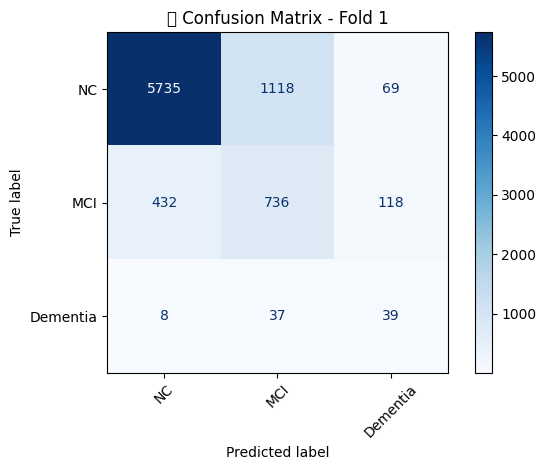


🔁 Fold 2/5
Epoch 1/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6127 - loss: 0.0477 - val_accuracy: 0.7768 - val_loss: 0.0127
Epoch 2/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7556 - loss: 0.0413 - val_accuracy: 0.7687 - val_loss: 0.0117
Epoch 3/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7537 - loss: 0.0387 - val_accuracy: 0.7859 - val_loss: 0.0112
Epoch 4/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7753 - loss: 0.0350 - val_accuracy: 0.7926 - val_loss: 0.0102
Epoch 5/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7935 - loss: 0.0338 - val_accuracy: 0.8031 - val_loss: 0.0106
Epoch 6/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7881 - loss: 0.0342 - val_accuracy: 0.7961 - val_loss: 0.0100
Epoch 7/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7919 - loss: 0.0326 - val_accuracy: 0.7988 - val_loss: 0.0100
Epoch 8/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7936 - loss: 0.0328 - val_

/tmp/ipython-input-19-1070015974.py:124: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


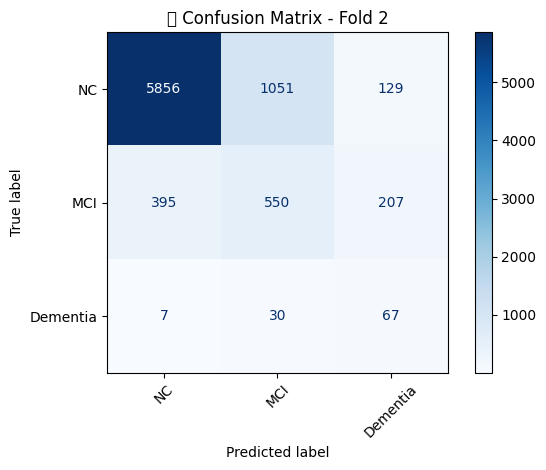


🔁 Fold 3/5
Epoch 1/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7287 - loss: 0.0444 - val_accuracy: 0.7829 - val_loss: 0.0109
Epoch 2/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7748 - loss: 0.0389 - val_accuracy: 0.7786 - val_loss: 0.0103
Epoch 3/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7722 - loss: 0.0376 - val_accuracy: 0.7788 - val_loss: 0.0100
Epoch 4/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7901 - loss: 0.0352 - val_accuracy: 0.7934 - val_loss: 0.0099
Epoch 5/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7935 - loss: 0.0335 - val_accuracy: 0.7957 - val_loss: 0.0095
Epoch 6/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7901 - loss: 0.0337 - val_accuracy: 0.7877 - val_loss: 0.0094
Epoch 7/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7898 - loss: 0.0340 - val_accuracy: 0.7897 - val_loss: 0.0094
Epoch 8/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7886 - loss: 0.0326 - val

/tmp/ipython-input-19-1070015974.py:124: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


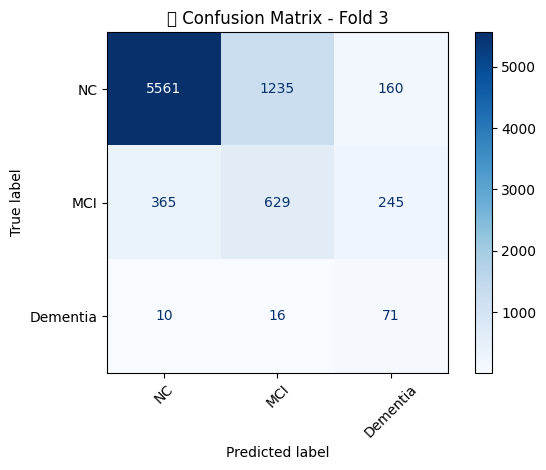


🔁 Fold 4/5
Epoch 1/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6348 - loss: 0.0465 - val_accuracy: 0.7657 - val_loss: 0.0142
Epoch 2/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7643 - loss: 0.0379 - val_accuracy: 0.7695 - val_loss: 0.0143
Epoch 3/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7728 - loss: 0.0355 - val_accuracy: 0.7634 - val_loss: 0.0125
Epoch 4/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7809 - loss: 0.0341 - val_accuracy: 0.7690 - val_loss: 0.0121
Epoch 5/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7811 - loss: 0.0349 - val_accuracy: 0.7921 - val_loss: 0.0139
Epoch 6/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7910 - loss: 0.0322 - val_accuracy: 0.7872 - val_loss: 0.0122
Epoch 7/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7938 - loss: 0.0321 - val_accuracy: 0.7862 - val_loss: 0.0123
Epoch 8/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7881 - loss: 0.0325 - val_

/tmp/ipython-input-19-1070015974.py:124: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


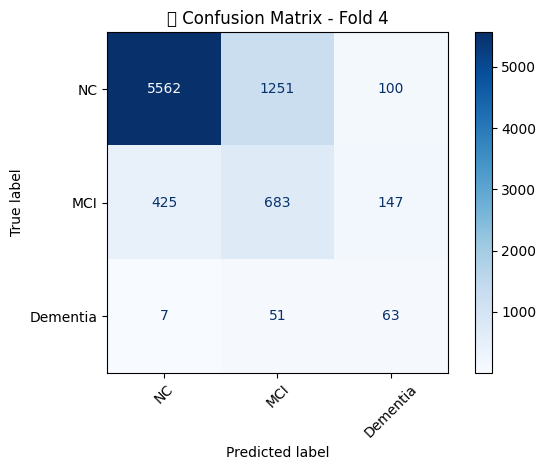


🔁 Fold 5/5
Epoch 1/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6225 - loss: 0.0463 - val_accuracy: 0.8026 - val_loss: 0.0129
Epoch 2/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7892 - loss: 0.0393 - val_accuracy: 0.7728 - val_loss: 0.0122
Epoch 3/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7755 - loss: 0.0365 - val_accuracy: 0.7886 - val_loss: 0.0121
Epoch 4/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7962 - loss: 0.0363 - val_accuracy: 0.8196 - val_loss: 0.0133
Epoch 5/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8147 - loss: 0.0325 - val_accuracy: 0.7842 - val_loss: 0.0108
Epoch 6/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7971 - loss: 0.0330 - val_accuracy: 0.8024 - val_loss: 0.0114
Epoch 7/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8045 - loss: 0.0320 - val_accuracy: 0.7765 - val_loss: 0.0108
Epoch 8/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7981 - loss: 0.0316 - val_

/tmp/ipython-input-19-1070015974.py:124: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


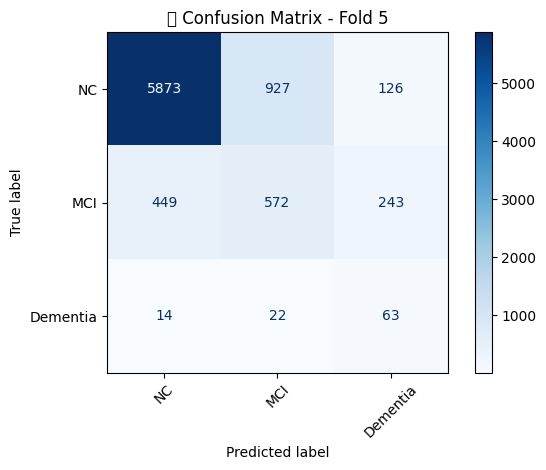


📊 Final Results (Across 5 Folds)
Avg IPW-F1 Score: 0.2784 ± 0.0188
  NC: F1 = 0.8734 ± 0.0096
  MCI: F1 = 0.4189 ± 0.0239
  Dementia: F1 = 0.2587 ± 0.0189

🔁 Transition Probability Matrix (Normalized Rows):
               Pred_NC  Pred_MCI  Pred_Dementia
True_NC         0.8226    0.1606         0.0168
True_MCI        0.3334    0.5116         0.1549
True_Dementia   0.0911    0.3089         0.6000


In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Masking
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# ========== CONFIGURATION ==========
input_features_dim = 10  # 🧠 1 cognitive state + 9 prognostic features

# ✅ Define class weights as constant tensor
class_weights = tf.constant([0.022, 0.101, 0.877], dtype=tf.float32)

# ✅ Custom weighted categorical crossentropy loss
def weighted_categorical_crossentropy(y_true, y_pred):
    weights = tf.reduce_sum(class_weights * y_true, axis=-1)
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return ce_loss * weights

# ========== BUILD LSTM MODEL FUNCTION ==========
def build_model():
    input_sequence = Input(shape=(None, input_features_dim), name='input_sequence')
    masked_input = Masking(mask_value=0.0, name='masking_layer')(input_sequence)
    lstm_output = LSTM(units=16, return_sequences=True, name='lstm_layer')(masked_input)
    cognition_state_output = Dense(units=3, activation='softmax', name='cognition_state')(lstm_output)
    model = Model(inputs=input_sequence, outputs=cognition_state_output, name="LSTM_CogClassifier")
    model.compile(
        optimizer=RMSprop(learning_rate=0.001),
        loss=weighted_categorical_crossentropy,
        metrics=['accuracy']
    )
    return model

# ========== Display Summary Once ==========
model = build_model()
print("\n✅ LSTM Classification-Only Model Summary:")
model.summary()
print("Total trainable parameters:", model.count_params())

# ✅ Prepare data
Y_array_int = np.array(Y_list).astype(int) - 1
flat_labels = Y_array_int.flatten()
unique, counts = np.unique(flat_labels, return_counts=True)
print("📊 Class Distribution in Y_array (flattened):")
for cls, count in zip(unique, counts):
    label = ["NC", "MCI", "Dementia"][cls] if cls in [0, 1, 2] else "Unknown"
    print(f"  Class {cls} ({label}): {count} instances")

normalized_ipw_weights = {0: 0.022, 1: 0.101, 2: 0.877}
print("\n✅ Normalized IPW Weights (for sample weighting):")
for cls, weight in normalized_ipw_weights.items():
    label = ["NC", "MCI", "Dementia"][cls]
    print(f"  Class {cls} ({label}): Weight = {weight:.3f}")

sample_weights_seq = []
for seq in Y_array:  # shape: (samples, 3)
    weights = [normalized_ipw_weights[int(label)] for label in seq]
    sample_weights_seq.append(weights)
sample_weights_seq = np.array(sample_weights_seq)

print("✅ X_final shape:", X_final.shape)
print("✅ Y_cls_final shape:", Y_cls_final.shape)
print("✅ sample_weights_seq shape:", sample_weights_seq.shape)

# ========== 5-FOLD CROSS VALIDATION ==========
kf = KFold(n_splits=5, shuffle=True, random_state=42)
ipw_f1_scores = []
f1_scores_per_class = []
conf_matrices = []

# 🧠 Store all predictions across folds for transition matrix
all_y_true_folds = []
all_y_pred_folds = []

for fold, (train_index, val_index) in enumerate(kf.split(X_final)):
    print(f"\n🔁 Fold {fold + 1}/5")
    X_train, X_val = X_final[train_index], X_final[val_index]
    y_train, y_val = Y_cls_final[train_index], Y_cls_final[val_index]
    w_train, w_val = sample_weights_seq[train_index], sample_weights_seq[val_index]

    model = build_model()
    model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        verbose=1,
        validation_data=(X_val, y_val, w_val)
    )

    Y_val_prob = model.predict(X_val)
    Y_val_pred = np.argmax(Y_val_prob, axis=-1)
    Y_val_true = np.argmax(y_val, axis=-1)

    y_true_flat = Y_val_true.flatten()
    y_pred_flat = Y_val_pred.flatten()

    # Store fold-wise predictions
    all_y_true_folds.append(Y_val_true)
    all_y_pred_folds.append(Y_val_pred)

    # IPW-F1 metric
    def ipw_f1_score(y_true, y_pred, labels=[0, 1, 2]):
        counts = Counter(y_true)
        weights = {cls: 1.0 / counts[cls] for cls in labels}
        f1s = f1_score(y_true, y_pred, labels=labels, average=None)
        weighted_f1 = sum(f1s[i] * weights[cls] for i, cls in enumerate(labels)) / sum(weights.values())
        return weighted_f1, f1s

    ipw_f1, f1_per_class = ipw_f1_score(y_true_flat, y_pred_flat)
    ipw_f1_scores.append(ipw_f1)
    f1_scores_per_class.append(f1_per_class)

    conf_mat = confusion_matrix(y_true_flat, y_pred_flat)
    conf_matrices.append(conf_mat)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['NC', 'MCI', 'Dementia'])
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"🧠 Confusion Matrix - Fold {fold + 1}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# 📊 ========== Final Results (Across 5 Folds) ==========
print("\n📊 Final Results (Across 5 Folds)")
print(f"Avg IPW-F1 Score: {np.mean(ipw_f1_scores):.4f} ± {np.std(ipw_f1_scores):.4f}")

f1_scores_per_class = np.array(f1_scores_per_class)
labels = ['NC', 'MCI', 'Dementia']
for i, label in enumerate(labels):
    class_scores = f1_scores_per_class[:, i]
    print(f"  {label}: F1 = {np.mean(class_scores):.4f} ± {np.std(class_scores):.4f}")

# 🧠 ========== Transition Matrix (Across All Folds) ==========
# Flatten all predictions and targets
y_true_all = np.concatenate([fold.flatten() for fold in all_y_true_folds])
y_pred_all = np.concatenate([fold.flatten() for fold in all_y_pred_folds])

transition_matrix = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1, 2])
transition_prob_matrix = (transition_matrix.T / transition_matrix.sum(axis=1)).T  # Normalize rows

transition_df = pd.DataFrame(
    transition_prob_matrix,
    index=["True_NC", "True_MCI", "True_Dementia"],
    columns=["Pred_NC", "Pred_MCI", "Pred_Dementia"]
)

print("\n🔁 Transition Probability Matrix (Normalized Rows):")
print(transition_df.round(4))


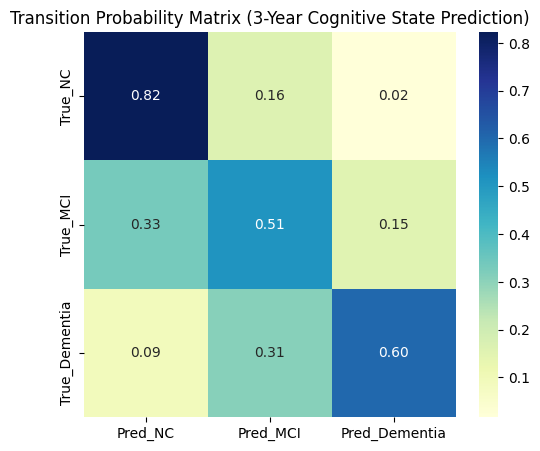

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(transition_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Transition Probability Matrix (3-Year Cognitive State Prediction)")
plt.show()



🔷 Results for 1-Year Visit
📊 IPW-F1 Score: 0.2829
🔍 F1 per class:
  NC: F1 = 0.9142
  MCI: F1 = 0.4665
  Dementia: F1 = 0.2687


/tmp/ipython-input-22-1865786071.py:48: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


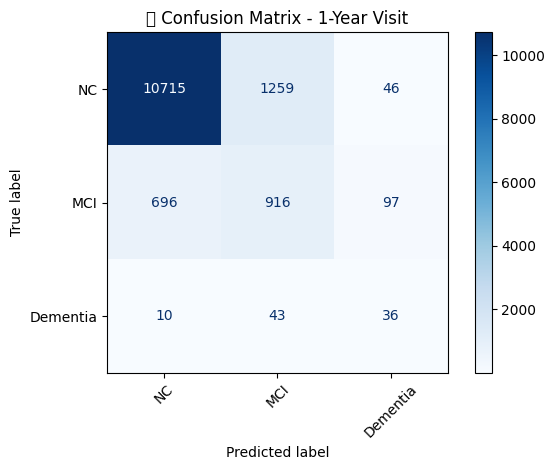


🔷 Results for 2-Year Visit
📊 IPW-F1 Score: 0.2440
🔍 F1 per class:
  NC: F1 = 0.8642
  MCI: F1 = 0.4164
  Dementia: F1 = 0.2249


/tmp/ipython-input-22-1865786071.py:48: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


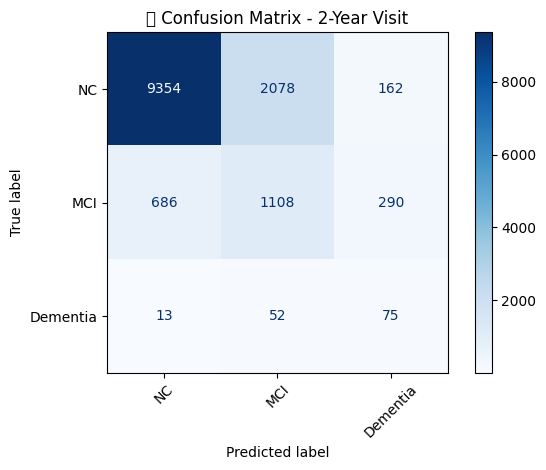


🔷 Results for 3-Year Visit
📊 IPW-F1 Score: 0.2954
🔍 F1 per class:
  NC: F1 = 0.8366
  MCI: F1 = 0.3915
  Dementia: F1 = 0.2710


/tmp/ipython-input-22-1865786071.py:48: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


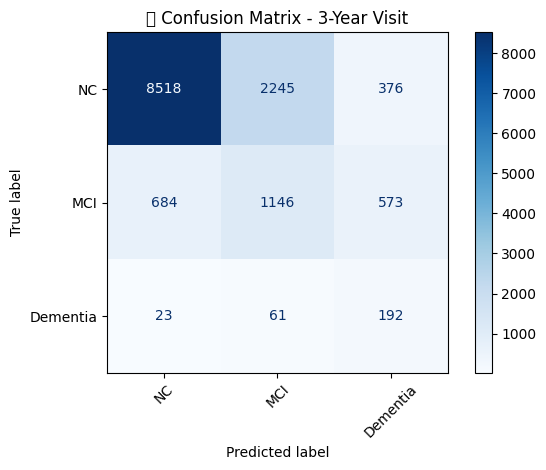

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# 👇 Function already in your code — but define here again if needed:
def ipw_f1_score(y_true, y_pred, labels=[0, 1, 2]):
    counts = Counter(y_true)
    weights = {cls: 1.0 / counts[cls] for cls in labels}
    f1s = f1_score(y_true, y_pred, labels=labels, average=None)
    weighted_f1 = sum(f1s[i] * weights[cls] for i, cls in enumerate(labels)) / sum(weights.values())
    return weighted_f1, f1s

# Concatenate all true and predicted labels across folds
y_true_all = np.concatenate([fold for fold in all_y_true_folds], axis=0)  # shape: (N_samples, 3)
y_pred_all = np.concatenate([fold for fold in all_y_pred_folds], axis=0)  # shape: (N_samples, 3)

visit_labels = ['1-Year Visit', '2-Year Visit', '3-Year Visit']
class_labels = ['NC', 'MCI', 'Dementia']

# 🔷 Results storage
visit_ipw_f1_scores = []
visit_f1_per_class = []

for visit in range(3):
    print(f"\n🔷 Results for {visit_labels[visit]}")

    # flatten the predictions & true labels for this visit
    y_true_visit = y_true_all[:, visit]
    y_pred_visit = y_pred_all[:, visit]

    # 🔷 IPW-F1
    ipw_f1, f1s = ipw_f1_score(y_true_visit, y_pred_visit)
    visit_ipw_f1_scores.append(ipw_f1)
    visit_f1_per_class.append(f1s)

    print(f"📊 IPW-F1 Score: {ipw_f1:.4f}")
    print("🔍 F1 per class:")
    for i, label in enumerate(class_labels):
        print(f"  {label}: F1 = {f1s[i]:.4f}")

    # 🔷 Confusion Matrix
    cm = confusion_matrix(y_true_visit, y_pred_visit, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"🧠 Confusion Matrix - {visit_labels[visit]}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()
